# Exploration 4. 프로젝트: 멋진 작사가 만들기


라이브러리 불러오기

In [2]:
import os, glob       # 시스템에 접근하는 라이브러리, 파일을 가져오는데 상용한다.
import re             # 정규표현식 라이브러리
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


__preprocess_sentence__ (문장을 전처리하는 함수)

- __소문자로 바꾸기(lower함수 사용)__  
    : 대문자가 섞인 단어와 소문자로만 이루어진 단어가 한 단어로 인식되도록 만들어주는 작업이다. 예를들어 Love와 love를 그냥 입력하면 다른 단어로 받아들여지게 되므로 소문자로 바꿔주는 작업을 한다
- __문장부호를 단어와 분리하기(정규표현식 함수 re.sub에 정규표현식 r"([?.!,¿])", r" \1"사용)__  
    : 같은 단어에 하나는 문장부호가 들어있고 한쪽은 없는 경우에도 다른 단어로 인식하기 때문에 문장부호를 단어와 스페이스바로 여백을 주어서 분리한다. 예를 들어 "How old are you?"의 you와 "you are..." 두 문장에서 you는 같은 you이지만 처음 것은 물음표가 있고 뒤에 것은 물음표가 없지만 같은 you이다. 하지만 물음표가 붙어있으면 컴퓨터에서는 둘을 다른 단어로 인식하게 된다. 그래서 전처리 과정에서 분리한다.
- __여러개의 공백을 하나의 공백으로 변환__(정규표현식 함수 re.sub에 정규표현식 r'[" "]+', " " 사용)
    : [" "]+ 이 정규표현식은 공백이 둘 이상 있는 경우를 의미하고 이럴 경우 하나의 띄어쓰기로 바꿔준다는 뜻이다   
    ex) long-time-ago. (한단어로 인식한다. 띄어쓰기가 아니라 -를 기준으로 단어가 나뉘므로)
    


자연어처리 분야에서 __모델의 입력문장을 소스문장(Source Sentence)__ , 정답이 되는 __모델의 출력문장을 타겟문장(Target sentence)__ 라고 부른다. X_train, y_train에 해당한다. 그래서 문장의 시작에  start 끝에 end를 넣었다. 

In [10]:
def preprocess_sentence(sentence):
    sentence=sentence.strip().lower() # 문장의 오른쪽 왼쪽의 공백을 지우고 소문자 변환
    sentence=re.sub(r"([?.!,¿])", r" \1", sentence)  # 문장부호의 양 옆을 각각 한칸 띄운다.
    sentence=re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿉니다.
    sentence=re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    #a-zA-Z?.!,¿가 아닌 모든 특수문자를 하나의 공백으로 바꾼다.
    sentence=sentence.strip() # 문자열에 양끝의 공백을 한번 더 삭제
    sentence=" ".join(['<start> ',sentence,' <end>']) # 문장시작은 <start> 끝에는 <end>를 추가한다.
    return sentence


In [9]:
#a-zA-Z?.!,¿가 아닌 모든 특수문자를 하나의 공백으로 바꾼다.
s="Does 100% pure water have a taste"
s=re.sub(r"[^a-zA-Z?.!,¿]+", " ",s) 
print(s) # 100% 단어가 공백으로 바뀐다. 특수문자와 숫자도 공백으로 바뀐 것을 볼수 있다.

Does pure water have a taste


 __토큰화(tokenize)__
 - 앞에서 전처리한 문장을 띄어쓰기를 기준으로 잘라내어 토큰으로 만들어낸다.

텐서플로우의 Tokenizer 패키지
- 위의 정제된 corpus를 토큰화해서 단어사전(vocabulary or dictionary)라고 말하며 숫자로 변환해준다. 이 과정을 벡터화(vectorize)이고, 숫자로 바꾼 데이터를 tensor라고 말한다.

tf.keras.preprocessing.text.Tokenizer
[참고할 사이트](https://wikidocs.net/31766)


In [11]:
def tokenize(corpus): 
    tokenizer=tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 단어장 크기12000
        filters=' ',     # preprocessed_sentence
        oov_token="<unk>"
    )
    # corpus를 사용해서 tokenizer 단어장을 만든다. 
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 사용해서 corpus를 Tensor로 만든다.
    tensor=tokenizer.texts_to_sequences(corpus)
    
    # input data의 시퀀스 크기를 
    #(길이가 짧은 문장 뒤(post)에 padding을 붙여서) 동일하게 만든다.
    # 문장 앞에 패딩을 붙이려면 pre라고 입력하면 됨
    tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    #print(tensor, tokenizer)
    return tensor, tokenizer


케라스의 LSTM을 사용한 텍스트 생성기 모델(TextGenerator) 

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size): # 단어장 크기, 단어를 임베딩할 사이즈, LSTM의 unit개수
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

그리고 마지막으로 가사를 생성시킬 함수(generate_text)

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])  
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### step1. 데이터 다운로드
- 아이펠에서 제공한 가사데이터를 다운받는다.

### Step2. 데이터 읽어오기

In [4]:

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)
print(txt_file_path)
raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])


/aiffel/aiffel/lyricist/data/lyrics/*
데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### step 3. 데이터 정제


- 노드 작성자의 조언대로 문장을 토큰화 했을 때 토큰의 개수가 15개 넘어가는 문장을 제외하였다.  

text_to_sequences 메서드를 사용해서 텍스트를 시퀀스형 데이터인 리스트로 만들어낸다. 2차원 리스트의 모양으로 데이터를 반환한다

데이터가 preprocess_sentence 함수에 의해 처리되면서 문장의 앞에 start 뒤에 end가 붙게 된다. 모델을 학습시킬 문장에는 end를 빼기 위해서 -1인덱스까지 자르고, 타겟문장에는 start를 잘라내기 위해서 1번 인덱스부터 끝의 문장까지 슬라이싱한다.

In [5]:
corpus=[]

for sentence in raw_corpus:
    if len(sentence) == 0: continue    # 빈 단어를 corpus에서 뺀다
    if sentence[-1] == ":" : continue  # 문장 끝에 콜론이 있는 경우 제외한다. 
                                        # 이건 가사라서 연극(이름에 콜론)과 달리 지워도 상관 없을 것 같지만 유지했다.
        
    # 앞에서 문장부호와 특수문자, 소문자 대문자 처리
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

tensor, tokenizer=tokenize(corpus)

tensor_=tokenizer.texts_to_sequences(corpus)

tensor=[]

for i in tensor_:
    if len(i)<=15:   # 15개 
        tensor.append(i)
        
tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

# 마지막토큰은 <end>가 아닌 <pad> 가능성이 높다.
src_input=tensor[:,:-1]
# t<start> 를 잘라서 타겟문장을 만든다.
tgt_input=tensor[:,1:]



[[   2   50    5 ...    0    0    0]
 [   2   17 2647 ...    0    0    0]
 [   2   35    7 ...    0    0    0]
 ...
 [   2  130    5 ...    0    0    0]
 [   2   23   89 ...    0    0    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f97cfd5d820>


### Step 4. 평가 데이터셋 분리

In [6]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input, test_size=0.2) 
# step3에서 전처리를 완성한 텐서(numpy 배열)를 train_test_split 으로 분할한다.

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256    # 학습시 배치사이즈
steps_per_epoch = len(src_input) // BATCH_SIZE # 한 에포크가 돌 동안 몇번의 스텝을 가느냐

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)) # 나뉘어진 데이터셋을 텐서플로 데이터셋으로 만든다.
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE)    # 데이터를 섞어주고
val_dataset = val_dataset.shuffle(BUFFER_SIZE)    

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)  # 학습할때 쓰이는 배치사이즈로 나눠준다.
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

#dataset

### Step 5. 인공지능 만들기

In [13]:
#Loss
embedding_size=[256,512]     # 임베딩할 차원의 수
hidden_size=[512,1024,2048]  # LSTM모델의 hidden
acc={}
for i in embedding_size:
    for j in hidden_size:
        model=TextGenerator(12000+1, i, j) # i: embadding_size, j: hidden_size
        optimizer=tf.keras.optimizers.Adam()
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        model.compile(loss=loss, optimizer=optimizer)
        tg=model.fit(train_dataset, epochs=10, validation_data=(val_dataset))
        acc["%d-%d"%(i,j)]=tg

Epoch 1/10
488/488 [==============================] - 40s 78ms/step - loss: 3.7877 - val_loss: 3.3858
Epoch 2/10
488/488 [==============================] - 37s 75ms/step - loss: 3.2852 - val_loss: 3.1982
Epoch 3/10
488/488 [==============================] - 38s 77ms/step - loss: 3.0931 - val_loss: 3.0435
Epoch 4/10
488/488 [==============================] - 38s 77ms/step - loss: 2.9613 - val_loss: 2.9449
Epoch 5/10
488/488 [==============================] - 37s 76ms/step - loss: 2.8604 - val_loss: 2.8748
Epoch 6/10
488/488 [==============================] - 38s 77ms/step - loss: 2.7795 - val_loss: 2.8157
Epoch 7/10
488/488 [==============================] - 38s 77ms/step - loss: 2.7084 - val_loss: 2.7691
Epoch 8/10
488/488 [==============================] - 38s 77ms/step - loss: 2.6433 - val_loss: 2.7284
Epoch 9/10
488/488 [==============================] - 38s 77ms/step - loss: 2.5825 - val_loss: 2.6923
Epoch 10/10
488/488 [==============================] - 38s 77ms/step - loss: 2.524

In [69]:
def find_acc(acc, key,hp):
    hp1,hp2=key.split("-")
    dd=pd.DataFrame(acc[key].history)
    return {hp[0]:hp1,hp[1]:hp2,"val_loss":dd.min()[1]}

dict_list=[]
for i in acc.keys():
    dict_list.append(find_acc(acc,i,("embedding","hidden_size")))
    
loss_df=pd.DataFrame(dict_list) # 가장 높은 accuracy는 0.574667
loss_df.loc[acc_df["val_loss"]<2.2].sort_values("val_loss", ascending=False) 

,embedding,hidden_size,val_loss
5,512,2048,2.152177


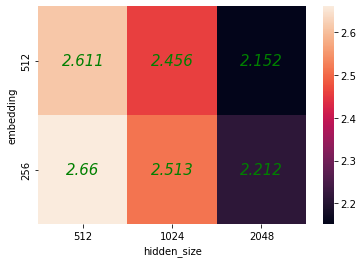

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_=loss_df.pivot(index="embedding", columns="hidden_size", values="val_loss")

loss_=loss_[['512','1024', '2048']]
loss_=loss_.reindex(["512","256"])

font3 = {'color':  'green',
      'style': 'italic',
      'size': 15}

sns.heatmap(loss_)
for i in range(loss_.shape[1]):
    for j in range(loss_.shape[0]):
        plt.text(i+0.5,j+0.5,round(loss_.iloc[j,i],3),ha='center',va='center', fontdict=font3)

plt.show()

### validation loss가 2.2 아래인 2.152가 된 모델은 embedding은 512, hidden_size는 2048개인 모델이었다.

In [74]:
from keras.models import load_model

model=TextGenerator(12000+1, 512, 2048) # i: embadding_size, j: hidden_size
optimizer=tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
model.compile(loss=loss, optimizer=optimizer)
model.fit(train_dataset, epochs=10, validation_data=(val_dataset))

Epoch 1/10
488/488 [==============================] - 264s 505ms/step - loss: 3.2788 - val_loss: 2.9039
Epoch 2/10
488/488 [==============================] - 248s 509ms/step - loss: 2.7189 - val_loss: 2.6363
Epoch 3/10
488/488 [==============================] - 249s 509ms/step - loss: 2.3876 - val_loss: 2.4508
Epoch 4/10
488/488 [==============================] - 249s 510ms/step - loss: 2.0638 - val_loss: 2.3140
Epoch 5/10
488/488 [==============================] - 249s 510ms/step - loss: 1.7637 - val_loss: 2.2172
Epoch 6/10
488/488 [==============================] - 249s 510ms/step - loss: 1.5042 - val_loss: 2.1596
Epoch 7/10
488/488 [==============================] - 249s 511ms/step - loss: 1.2976 - val_loss: 2.1375
Epoch 8/10
488/488 [==============================] - 249s 510ms/step - loss: 1.1485 - val_loss: 2.1427
Epoch 9/10
488/488 [==============================] - 249s 511ms/step - loss: 1.0582 - val_loss: 2.1622
Epoch 10/10
488/488 [==============================] - 249s 510m

### text generator가 작사한 문장들이다.
- 간단한 초보 영단어들을 넣어보니,어쩐지 추상적인 느낌이 드는 그럴싸한 가사들이 만들어졌다.

In [78]:
generate_text(model, tokenizer, init_sentence="<start> i need you ", max_len=20)

'<start> i need you to be here with me <end> '

In [84]:
generate_text(model, tokenizer, init_sentence="<start> i said", max_len=20)

'<start> i said , no , no , no <end> '

In [90]:
generate_text(model, tokenizer, init_sentence="<start> we live ", max_len=20)

'<start> we live in cities you ll never see on screen <end> '

In [93]:
generate_text(model, tokenizer, init_sentence="<start> my life ", max_len=20)

'<start> my life s a mess <end> '

In [95]:
generate_text(model, tokenizer, init_sentence="<start> you never ", max_len=20)

'<start> you never thought that hip hop would take it this far <end> '

## 회고
- 언어모델을 돌려본 것 자체가 처음이었다. 물론 지난 프로젝트에 사용했던 가위바위보 모델 만들기도 시간이 오래걸렸지만, 하나의 모델을 만들기 위해서 10epoch를 돌리는데만해도 가장 작은 모델이 한 epoch당 40초 가량 시간이 들었다. 가장 무거운 모델은 한 에폭당 249초가 걸렸다. 학습시간이 오래 걸려서 모델을 돌려놓고 기다리다가 깜빡 졸았는데 너무 푹자버려서 다음날 아침에 일어나보니 LMS가 로그아웃 된 일도 있었고, 구글 colab에 모델을 걸어놓고 외출하고 돌아왔는데 오래 마우스 반응이 없어서 런타임이 종료된 일도 있었다. 이 사건을 계기로 꼭 모델을 만들고 어떻게하면 모델 저장하고 다시 로드해서 쓰는 방법을 꼭 익혀서 자칫 잘못해서 모델이 일부 날라가도 이어서 학습시킬수 있는 환경을 만들고 싶다. 
- 전반적으로 낯선 파트이라서 어려웠지만 자연어처리 데이터를 전처리하는 방법에 있어서 정규표현식을 자유자제로 다루는 스킬이 중요함을 느꼈다. 코드를 보면 전처리 과정에서 반 정도가 정규표현식의 패턴으로 데이터의 불필요한 정보는 지우는 일이 많았다.
- 노드에서 제시된 것처럼 대본의 텍스트를 다룰때는 문장 끝에 콜론이 붙을 경우(극본의 이름을 나타내는 표시) 그 문장을 포함시키지 않는등 NLP가 사용되는 텍스트에 대한 이해도 역시 중요하다는 생각이 들었다.  

- 위의 히트맵을 보면 __embedding 사이즈가 높고, hidden의 사이즈가 큰쪽__ 이 loss가 많이 줄어들었음을 알수 있었다. validation loss가 2.2 아래로 떨어진 모델은 embedding은 512, hidden_size는 2048인 모델이다. 이정도면 모델의 복잡도가 큰 모델이라고 생각했었는데 검증데이터셋의 loss가 꾸준히 착착 줄어드는 것을 보고 NLP모델을 충분히 학습하고 결과물을 내기 위해서는 많은 리소스와 시간, 데이터를 필요로 하는 모델이라고 생각했다. 